## References:
- https://arxiv.org/pdf/2004.11362.pdf
- https://towardsdatascience.com/contrastive-loss-for-supervised-classification-224ae35692e7

## Initial setup

In [1]:
!pip install tfds-nightly tensorflow matplotlib

In [1]:
import tensorflow as tf
print(tf.__version__)

2023-06-24 05:34:30.520685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-24 05:34:31.548647: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [2]:
!nvidia-smi

Sat Jun 24 05:34:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8     4W /  80W |    431MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install wandb
import wandb
wandb.login()

wandb: Currently logged in as: burkinabe (master-thesis-uvbf). Use `wandb login --relogin` to force relogin


True

In [9]:
!wget https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py

--2023-06-23 18:29:24--  https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5169 (5.0K) [text/plain]
Saving to: ‘losses.py.1’

losses.py.1         100%[===================>]   5.05K  --.-KB/s    in 0s      

2023-06-23 18:29:24 (79.5 MB/s) - ‘losses.py.1’ saved [5169/5169]



In [4]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
from wandb.keras import WandbCallback
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import losses
import time

tf.random.set_seed(666)
np.random.seed(666)

tfds.disable_progress_bar()

/home/aksavadogo/anaconda3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Pets dataset

In [15]:
!git clone https://github.com/burkinabe/data.git

Cloning into 'data'...
remote: Enumerating objects: 1772, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 1772 (delta 2), reused 140 (delta 2), pack-reused 1632
Receiving objects: 100% (1772/1772), 875.84 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (62/62), done.
Updating files: 100% (1887/1887), done.


In [5]:
train_data_dir = "data/test"
batch_size = 16
img_height = 248
img_width = 248

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_dir,
  #validation_split=0.4,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1600 files belonging to 2 classes.


2023-06-24 05:35:00.036235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-24 05:35:00.224872: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
val_data_dir = "data/val"

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_data_dir,
  #validation_split=0.81,
  #subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 864 files belonging to 2 classes.


In [9]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malicious']


2023-06-24 05:35:09.706412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1600]
	 [[{{node Placeholder/_0}}]]
2023-06-24 05:35:09.706732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]


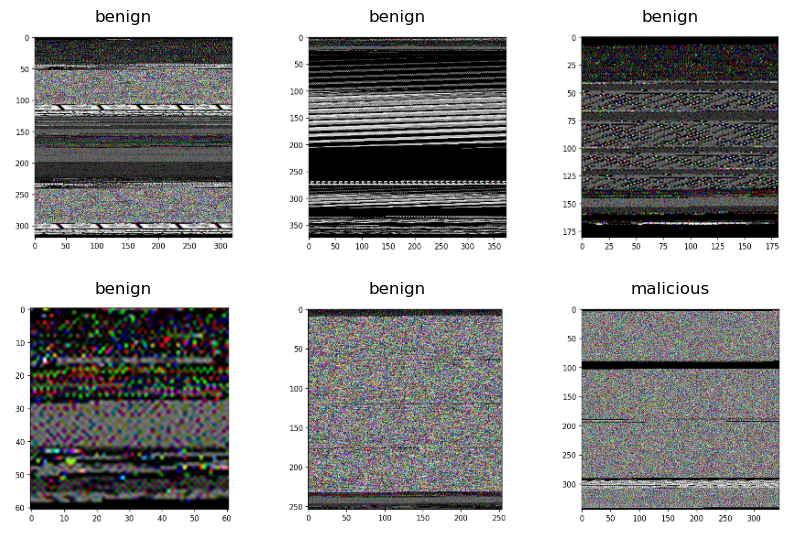

In [10]:
# Reference: https://keras.io/guides/transfer_learning/
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data pipeline

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2023-06-24 05:35:13.577380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-06-24 05:35:13.577799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]


(16, 248, 248, 3)
(16,)


In [12]:
AUTO = tf.data.experimental.AUTOTUNE

@tf.function
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (img_height, img_width))

    return (image, label)

train_ds = (
    train_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(batch_size)
    .prefetch(AUTO)
)


## Model building

In [13]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [14]:

# Encoder Network
def encoder_net():
    inputs = Input((img_height, img_width, 3))
    normalization_layer = UnitNormLayer()

    encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
    encoder.trainable = True

    embeddings = encoder(inputs, training=True)
    embeddings = GlobalAveragePooling2D()(embeddings)
    norm_embeddings = normalization_layer(embeddings)

    encoder_network = Model(inputs, norm_embeddings)

    return encoder_network

# Projector Network
def projector_net():
    projector = tf.keras.models.Sequential([
        Dense(128, activation="relu"),
        UnitNormLayer()
    ])

    return projector

## Running forward passes on a single image

In [15]:
encoder_r = encoder_net()
projector_z = projector_net()

images, _ = next(iter(train_ds))
r = encoder_r(images[0], 0)
z = projector_z(r)

print(tf.shape(r))
print(tf.shape(z))

2023-06-24 05:35:28.350275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]
2023-06-24 05:35:28.350679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1600]
	 [[{{node Placeholder/_4}}]]


tf.Tensor([  16 2048], shape=(2,), dtype=int32)
tf.Tensor([ 16 128], shape=(2,), dtype=int32)


## Training the encoder and the projector

In [16]:
optimizer = tf.keras.optimizers.Adam()

In [17]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels, metric='cosine')

	gradients = tape.gradient(loss,
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients,
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

In [18]:
from tensorflow.python.ops.numpy_ops import np_config
# Enable numpy-related methods in TensorFlow
np_config.enable_numpy_behavior()

In [19]:
tf.config.run_functions_eagerly(True)

  0%|          | 0/60 [00:00<?, ?it/s]

supervised_contrastive_loss : 0.3785187304019928
Epoch: 0 Loss: 0.379
supervised_contrastive_loss : 0.17815257608890533
supervised_contrastive_loss : 0.24063095450401306
supervised_contrastive_loss : 0.21605844795703888
supervised_contrastive_loss : 0.1141364723443985
supervised_contrastive_loss : 0.14489147067070007
supervised_contrastive_loss : 0.23096910119056702
supervised_contrastive_loss : 0.2907520830631256
supervised_contrastive_loss : 0.1976800262928009
supervised_contrastive_loss : 0.1120959147810936
supervised_contrastive_loss : 0.15300647914409637
Epoch: 10 Loss: 0.153
supervised_contrastive_loss : 0.1596793681383133
supervised_contrastive_loss : 0.10164812952280045
supervised_contrastive_loss : 0.1404062658548355
supervised_contrastive_loss : 0.11469496786594391
supervised_contrastive_loss : 0.09598084539175034
supervised_contrastive_loss : 0.15392442047595978
supervised_contrastive_loss : 0.1899709701538086
supervised_contrastive_loss : 0.15763045847415924
supervised_cont

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
f

supervised_contrastive_loss : 0.09232694655656815
training_time : 2309.945517063141


findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not fo

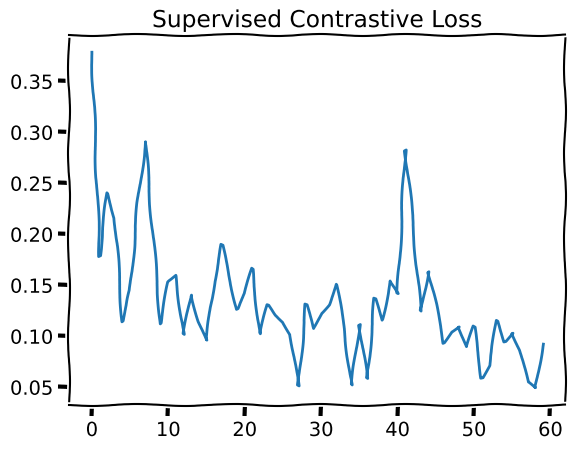

In [20]:
#wandb.init(project="scl", entity="authors", id="supervised-contrastive-crctd")
EPOCHS = 60
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):
    epoch_loss_avg = tf.keras.metrics.Mean()

    for (images, labels) in train_ds:
        #print(labels.shape)
        loss = train_step(images[0], labels[0])
        epoch_loss_avg.update_state(loss)

    train_loss_results.append(epoch_loss_avg.result())
    print("supervised_contrastive_loss : {}".format(epoch_loss_avg.result()))

    if epoch % LOG_EVERY == 0:
        print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
print("training_time : {}".format((end - start)))

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()

## Supervised training

In [21]:
validation_ds = (
    val_ds
    .map(preprocess_image, num_parallel_calls=AUTO)
    .shuffle(100)
    .batch(batch_size)
    .prefetch(AUTO)
)

/home/aksavadogo/anaconda3/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [30]:
def supervised_model():
    inputs = Input((img_height, img_width, 3))
    encoder_r.trainable = False
    print(inputs.shape)
    r = encoder_r(inputs, training=False)
    outputs = Dense(1)(r)
    print(outputs.shape)
    supervised_model = Model(inputs, outputs)

    return supervised_model

In [25]:
from tensorflow import keras

In [31]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))

In [ ]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    print(img[0].shape)
    return (img[0], label)

In [ ]:
validation_ds = validation_ds.map(_normalize_img)
train_ds = train_ds.map(_normalize_img)

(None, 248, 248, 3)
(None, 248, 248, 3)


In [ ]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
	metrics=[tf.keras.metrics.BinaryAccuracy()])

#wandb.init(project="scl", entity="burkinabe")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[CustomCallback(), es])

(None, 248, 248, 3)
(None, 1)
Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
Epoch 1/50
...Training: start of batch 0; got log keys: []


In [ ]:
# Lowering the learning rate
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	metrics=[tf.keras.metrics.BinaryAccuracy()])

wandb.init(project="scl", entity="authors", id="low-lr")
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2,
	restore_best_weights=True, verbose=2)

supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=50,
	callbacks=[WandbCallback(), es])

Epoch 1/50
309/309 [==============================] - 45s 147ms/step - loss: 0.5850 - binary_accuracy: 0.5262 - val_loss: 0.5164 - val_binary_accuracy: 0.7357
Epoch 2/50
309/309 [==============================] - 43s 141ms/step - loss: 0.4098 - binary_accuracy: 0.9144 - val_loss: 0.4071 - val_binary_accuracy: 0.8773
Epoch 3/50
309/309 [==============================] - 44s 142ms/step - loss: 0.3026 - binary_accuracy: 0.9555 - val_loss: 0.3434 - val_binary_accuracy: 0.8891
Epoch 4/50
309/309 [==============================] - 43s 140ms/step - loss: 0.2357 - binary_accuracy: 0.9620 - val_loss: 0.3061 - val_binary_accuracy: 0.8951
Epoch 5/50
309/309 [==============================] - 43s 138ms/step - loss: 0.1922 - binary_accuracy: 0.9638 - val_loss: 0.2841 - val_binary_accuracy: 0.8971
Epoch 6/50
309/309 [==============================] - 43s 139ms/step - loss: 0.1629 - binary_accuracy: 0.9652 - val_loss: 0.2712 - val_binary_accuracy: 0.8985
Epoch 7/50
309/309 [==========================

With more training for the encoder and the projector, we would have got better results. We did not use any augmentation policy for either of the trainings above, so including that would have also helped us enhance the performance.

## Serialize the model weights to GCS

In [ ]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration"
!gcloud config set project $PROJECT_ID

Updated property [core/project].


In [ ]:
!gsutil mb gs://supervised-contrastive

Creating gs://supervised-contrastive/...


In [ ]:
time_now = time.time()
encoder_r.save_weights("encoder_r_" + str(time_now) + ".h5")
projector_z.save_weights("projector_z" + str(time_now) + ".h5")

!gsutil -m cp -r *.h5 gs://supervised-contrastive/

Copying file://encoder_r_1590489813.9405909.h5 [Content-Type=application/octet-stream]...
Copying file://projector_z1590489813.9405909.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 2 objects/91.2 MiB.                                     
